In [1]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString

In [2]:
day1_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_forecasts_2024.geojson')

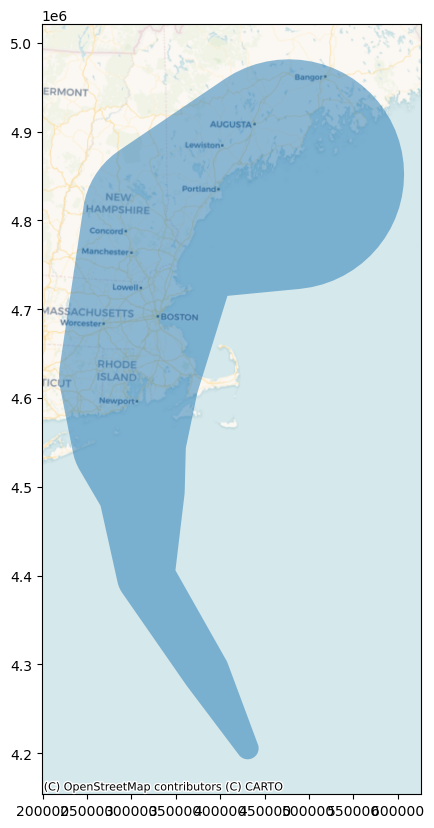

In [3]:
#put it in meters
day1_forecast_utm = (day1_forecast
                     .to_crs(day1_forecast.estimate_utm_crs())
                    )

day1_forecast_utm["x"] = day1_forecast_utm.geometry.x
day1_forecast_utm["y"] = day1_forecast_utm.geometry.y

day1_forecast_utm
#centroids
day1_forecast_centroid_utm = (day1_forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=day1_forecast_utm.crs ))
    )


day1_forecast_centroid_utm

dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

#distances between points and centroids
dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

radii = dist_gdf.groupby("forecastHour", as_index=False)[["dist_m"]].mean()
radii

#.pipe switches the grouped dataframe to a geodataframe
day1_forecast_dist_m_utm = (day1_forecast_centroid_utm.merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
day1_forecast_dist_m_utm

#makes points into circles
day1_forecast_circle  = day1_forecast_dist_m_utm
day1_forecast_circle['geometry'] = day1_forecast_circle.geometry.buffer(day1_forecast_circle.dist_m)
day1_forecast_circle
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts['geometry']

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

# Convert to a GeoDataFrame
cone_of_uncertainty = gpd.GeoDataFrame(geometry=[visualizeUncertainty(day1_forecast_circle)], crs=day1_forecast_circle.crs)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

cone_of_uncertainty.plot(ax=ax, alpha=0.5)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )


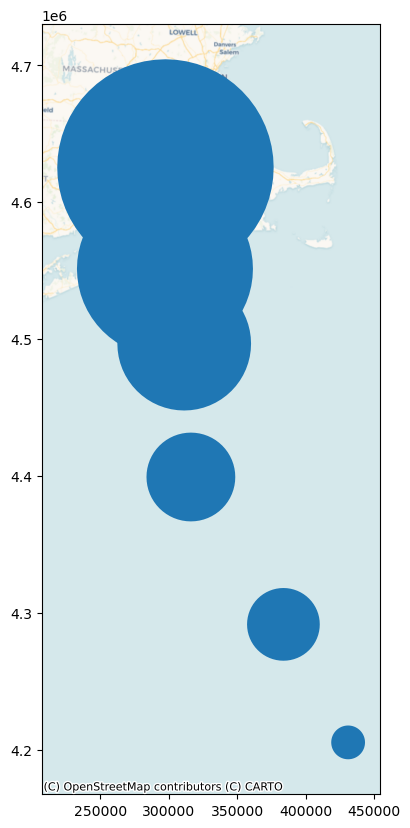

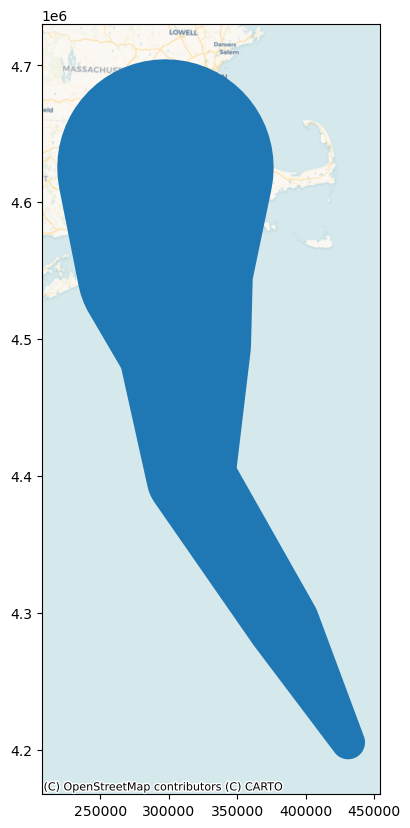

In [4]:
day1_forecast_circle_partial = day1_forecast_circle.iloc[:6,:] #(For 72 hourss)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

day1_forecast_circle_partial.plot(ax=ax)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

cone = visualizeUncertainty(day1_forecast_circle_partial)
fig, ax = plt.subplots(1, 1, figsize=(20,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, )


ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()

In [5]:
import ee
import geemap
ee.Authenticate()
ee.Initialize()

In [6]:
Map = geemap.Map()

In [32]:
import shapely.geometry
from pyproj import Transformer

# Assuming the UTM zone is 33N. Replace '33N' with the appropriate UTM zone for your data.
transformer = Transformer.from_crs("epsg:26919", "epsg:4326", always_xy=True)

# Reproject the UTM polygon to WGS84.
cone2 = shapely.ops.transform(transformer.transform, cone)

# Convert Shapely polygon to GeoJSON format.
geojson = shapely.geometry.mapping(cone2)

# Load the GeoJSON into GEE as a feature.
cone_GEE = ee.Feature(geojson)


myShapefile = ee.FeatureCollection('users/yourusername/yourshapefile');

# Remove misclassified pixels in areas with slopes greater than 5%
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')
# Load the GeoTIFF as an Earth Engine Image
#coastline = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'United States of America'))
coastline = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'United States of America'))#.filterBounds(geojson))
# Define visualization parameters with min and max values
vis_params = {
    'min': -25,      
    'max': 700   
}

slope_vis = {
    'min': 0,          
    'max': 30,        
    'palette': "GnBu"  
}

#TO-DO
#Social Vulnerability
#Slope Below 5 Percent (want to evacuate)
#Lowest elevation areas
#____________________________________For Elevation:
#ATEF's GOAT CODE:
# import necessary libraries
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'United States of America'))
image1 = ee.Image('projects/remote-sensing-project-428819/assets/n42_w071_1arc_v3')
image2 = ee.Image('projects/remote-sensing-project-428819/assets/n42_w072_1arc_v3')

# Define visualization parameters with min and max values
pop_viz = {
    "min": 0.0,
    "max": 1000.0,
    "palette": ["#f7fcf0", "#e0f3f8", "#bfd3c1", "#f4a582", "#d73027"]}
    
vis_params = {
    'min': -25,            # Minimum value for color scaling
    'max': 700,        # Maximum value for color scaling
    'palette': ['blue', 'green', 'yellow', 'red']}  # Color palette (optional)

slopeMask = slope.lt(5)
maskedSlope = slope.updateMask(slopeMask)

pop_dataset = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").first()
pop_raster = pop_dataset.select("population_count")
pop_exposed = pop_raster.updateMask(slopeMask)
 #all areas below 5

# Create an interactive map
Map = geemap.Map(center=[42.407, -71.384], zoom=5)
# Display the map
# # If you want to visualize the feature, you can use geemap.
Map.addLayer(srtm, vis_params, 'Large DEM-Map (SRTM)')
Map.addLayer(image1, vis_params, 'DEM-Map Tile1') #DON"T NEED
Map.addLayer(image2, vis_params, 'DEM=Map Tile2') #DON't TNEED
Map.addLayer(slope, slope_vis, 'slope')
Map.addLayer(maskedSlope, {min: 0, max: 5, 'palette': ['FFDBBB']}, 'Slope < 5%');
Map.addLayer(pop_exposed, pop_viz, "Population Density")
Map.addLayer(cone_GEE, {}, 'Cone Day1')
Map.centerObject(cone_GEE, 10) 
Map.addLayer(coastline, {}, 'coastline')
Map

# 93E9BE
# FFDBBB
# If you want to visualize the feature, you can use geemap.

#______________________________________________________________________________


Map(center=[40.65396823011885, -71.15131317312112], controls=(WidgetControl(options=['position', 'transparent_…

In [26]:
import json
geojson = coastline.getInfo()
with open('coastline.geojson', 'w') as f:
    json.dump(geojson, f)

In [30]:
gdf = gpd.read_file('coastline.geojson')
gdf.area

0    21.042443
dtype: float64

In [9]:
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'United States of America'))
print("Point FeatureCollection's geometry", roi.geometry());

Point FeatureCollection's geometry ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.loadTable",
                "arguments": {
                  "tableId": {
                    "constantValue": "FAO/GAUL_SIMPLIFIED_500m/2015/level0"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.equals",
                "arguments": {
                  "leftField": {
                    "constantValue": "ADM0_NAME"
                  },
                  "rightValue": {
                    "constantValue": "United States of America"
                  }
                }
       

In [10]:
#levelone. FAOgoal

In [11]:
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'United States of America'))
USA_geo = roi.geometry()
USA_geo 

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.loadTable",
                "arguments": {
                  "tableId": {
                    "constantValue": "FAO/GAUL_SIMPLIFIED_500m/2015/level0"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.equals",
                "arguments": {
                  "leftField": {
                    "constantValue": "ADM0_NAME"
                  },
                  "rightValue": {
                    "constantValue": "United States of America"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [14]:
#gpd_dataframe
#ee.FeatureCollection.geometry(maxError)

NameError: name 'maxError' is not defined

In [ ]:
#Making composite image
startDate = ee.Date('2024-01-01');
endDate = startDate.advance(1, 'year');
 
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
  .filter(ee.Filter.date(startDate, endDate))\
  .filter(ee.Filter.bounds(USA_geo));
#______________________________________________________________________

In [ ]:
#Apply cloud mask
# maskL8sr = function(image) {\
#     qaMask = image.select('QA_PIXEL')
# }
def maskL8sr(image):
     qaMask = image.select('QA_PIXEL')\
     .bitwiseAnd(parseInt('11111', 2)).eq(0);
     saturationMask = image.select('QA_RADSAT').eq(0);

    #Apply the scaling factors to the appropriate bands.
     opticalBands = image.select('SR_B.')\
     .multiply(0.0000275).add(-0.2);
     thermalBands = image.select('ST_B.*')
    .multiply(0.00341802).add(149.0);

    
    

# collection = collection.map(maskL8sr);

In [ ]:
# # # Sum pixel values of exposed population raster
# stats = population_exposed.reduceRegion(reducer= ee.Reducer.sum(),
#                                         geometry= roi, #cuz i hav reigon of interest here
#                                         scale= 250,
#                                         maxPixels=1e9)

# # # # Get number of exposed people as integer
# number_pop_exposed = stats.getNumber('population_count').round()
# number_pop_exposed 

In [ ]:
# print(f'Calculation result --> Estimated Exposed population in areas with less th:\n{number_pop_exposed.getInfo()}')

In [ ]:
ne_10m_coastline

In [34]:
!unzip ne_10m_coastline.zip

Archive:  ne_10m_coastline.zip
  inflating: ne_10m_coastline.README.html  
 extracting: ne_10m_coastline.VERSION.txt  
 extracting: ne_10m_coastline.cpg    
  inflating: ne_10m_coastline.dbf    
  inflating: ne_10m_coastline.prj    
  inflating: ne_10m_coastline.shp    
  inflating: ne_10m_coastline.shx    
